In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

*   First, we load the dataset `weatherAUS.csv` into a pandas DataFrame named `data`. This dataset contains weather observations from various locations in Australia. The following code snippet is used to load the data and print the initial shape of the dataset, which indicates the number of rows and columns it contains.
*   This output tells us that the dataset consists of 145,460 observations (rows) and 23 features (columns), providing a comprehensive overview of the weather conditions in Australia across different locations and times.



In [ ]:
# Load the dataset
data = pd.read_csv('/content/sample_data/weatherAUS.csv')
print("Initial dataset shape:", data.shape)


Initial dataset shape: (145460, 23)




*   After loading the dataset, we aim to transform the 'Date' column to separate it into three distinct columns: 'Year', 'Month', and 'Day'. This transformation allows for easier analysis and manipulation of the dataset based on specific time frames. The 'Date' column is first converted into a pandas datetime format. Then, we extract the year, month, and day as separate columns. Finally, the original 'Date' column is dropped from the dataset since it's no longer needed after the extraction. The following code snippet accomplishes this transformation:
*   This output shows the first five rows of the dataset, demonstrating how the 'Date' column has been successfully split into 'Year', 'Month', and 'Day' columns, enhancing the dataset's structure for further analysis.



In [ ]:
# Transform 'Date' column into 'Year', 'Month', and 'Day'
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data.drop('Date', axis=1, inplace=True)  # Remove the original Date column
print("After transforming 'Date' column:", data[['Year', 'Month', 'Day']].head())

After transforming 'Date' column:    Year  Month  Day
0  2008     12    1
1  2008     12    2
2  2008     12    3
3  2008     12    4
4  2008     12    5




*   Before we proceed with splitting the dataset into features and target variables for machine learning models, it's crucial to clean the data and ensure it's in the right format. This involves two key steps:

1. **Dropping Rows Where the Target Variable is Missing:** Since the prediction of rain tomorrow ('RainTomorrow') is our primary objective, rows with missing values in the 'RainTomorrow' column are not useful for training predictive models. Therefore, we remove these rows from the dataset.

2. **Encoding the Target Variable:** The 'RainTomorrow' column contains categorical data ('Yes' or 'No'), which needs to be encoded into a numerical format that can be processed by machine learning algorithms. We map 'No' to 0 and 'Yes' to 1.

3. **Ensuring No NaN Values in the Target Variable:** It's critical to confirm that there are no NaN values left in the 'RainTomorrow' column after encoding, as NaN values can cause errors in model training.

Finally, we split the dataset into features (X) and the target variable (y) after cleaning and encoding. The features include all columns except 'RainTomorrow', while the target is the 'RainTomorrow' column itself. Here's how we accomplish these steps:
*   These outputs indicate the successful cleaning and preparation of the dataset, with the 'RainTomorrow' column encoded and the dataset ready for the split into features and target variable.



In [ ]:
# Drop rows where the target variable is missing BEFORE splitting
data.dropna(subset=['RainTomorrow'], inplace=True)
print("After dropping rows with missing 'RainTomorrow':", data.shape)

# Encode the target variable 'RainTomorrow'
data['RainTomorrow'] = data['RainTomorrow'].map({'No': 0, 'Yes': 1})
print("After encoding 'RainTomorrow':", data['RainTomorrow'].value_counts())

# Ensure no NaN values in the target variable
assert data['RainTomorrow'].isnull().sum() == 0, "NaN values found in 'RainTomorrow'"

# Split the dataset into features (X) and target (y) AFTER cleaning and encoding
X = data.drop('RainTomorrow', axis=1)
y = data['RainTomorrow']

After dropping rows with missing 'RainTomorrow': (142193, 25)
After encoding 'RainTomorrow': 0    110316
1     31877
Name: RainTomorrow, dtype: int64


In [ ]:
# Split X and y into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")

Training data shape: (113754, 24), Test data shape: (28439, 24)


Once the dataset is cleaned, encoded, and split into features (X) and the target variable (y), the next step is to prepare the data for machine learning models. This preparation includes selecting numerical and categorical columns for different preprocessing pipelines. Numerical columns may require scaling or normalization, while categorical columns often need encoding to transform them into a format suitable for model training.

### Selecting Columns for Preprocessing

We categorize the features into numerical and categorical columns based on their data types:

- **Numerical Columns:** These include columns with data types `int64` and `float64`. Additionally, the columns 'Year', 'Month', and 'Day', derived from the 'Date' column, are explicitly added to the numerical list as they represent time components in numerical format.
  
- **Categorical Columns:** These are columns with the data type `object`, indicating textual or categorical data that will need to be encoded before modeling.

Here is the code snippet used to select these columns and print their names:

In [ ]:
# Select columns for preprocessing
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist() + ['Year', 'Month', 'Day']
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print(f"Numerical columns: {numerical_cols}\nCategorical columns: {categorical_cols}")

Numerical columns: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'Year', 'Month', 'Day', 'Year', 'Month', 'Day']
Categorical columns: ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']


With the features classified into numerical and categorical columns, the next step in preparing our data for machine learning involves creating preprocessing pipelines. These pipelines are designed to handle missing values and apply appropriate transformations to each type of data, ensuring that our dataset is ready for modeling.

### Creating Preprocessing Pipelines

The preprocessing steps are different for numerical and categorical data:

- **Numerical Data Preprocessing:** For numerical columns, we first handle missing values by imputing them with the column mean. Then, we scale the data using `StandardScaler` to normalize its distribution, making it more suitable for algorithms that are sensitive to the scale of the input features.

- **Categorical Data Preprocessing:** Categorical columns require filling missing values with the most frequent category (mode) and then converting the categories into a numerical format using one-hot encoding. One-hot encoding creates binary columns for each category, which is essential for models that cannot handle categorical data directly.

Here's how we define these pipelines using `sklearn`'s `Pipeline` and preprocessing classes:

In [ ]:
# Create preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


After setting up the individual preprocessing pipelines for numerical and categorical data, we now combine these steps into a single preprocessor. This comprehensive approach allows us to apply consistent preprocessing to both training and test datasets efficiently. Here's how we achieve this:

### Combining Preprocessing Steps

We use `ColumnTransformer` to apply the respective preprocessing pipelines to numerical and categorical columns simultaneously. This approach not only streamlines the preprocessing workflow but also ensures that our data is correctly prepared for machine learning models.

In [ ]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply preprocessing to both training and test data
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

# Generate feature names from the preprocessor
numerical_features = numerical_cols
categorical_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
all_feature_names = numerical_features + list(categorical_features)

# Convert the preprocessed training and test data back into pandas DataFrames
X_train_df = pd.DataFrame(X_train_prepared.toarray(), columns=all_feature_names)
X_test_df = pd.DataFrame(X_test_prepared.toarray(), columns=all_feature_names)

# Save the preprocessed datasets
X_train_df.to_csv('/content/sample_data/X_train_preprocessed.csv', index=False)
X_test_df.to_csv('/content/sample_data/X_test_preprocessed.csv', index=False)
y_train.to_csv('/content/sample_data/y_train.csv', index=False)
y_test.to_csv('/content/sample_data/y_test.csv', index=False)

print("Preprocessed datasets saved.")

Preprocessed datasets saved.


In [ ]:
# You can inspect the preprocessed features like this
feature_names = preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_cols)
all_feature_names = numerical_cols + feature_names.tolist()  # Combine numerical and categorical feature names
# Displaying the feature names
print("Feature names after preprocessing:", all_feature_names)

Feature names after preprocessing: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'Year', 'Month', 'Day', 'Year', 'Month', 'Day', 'Location_Adelaide', 'Location_Albany', 'Location_Albury', 'Location_AliceSprings', 'Location_BadgerysCreek', 'Location_Ballarat', 'Location_Bendigo', 'Location_Brisbane', 'Location_Cairns', 'Location_Canberra', 'Location_Cobar', 'Location_CoffsHarbour', 'Location_Dartmoor', 'Location_Darwin', 'Location_GoldCoast', 'Location_Hobart', 'Location_Katherine', 'Location_Launceston', 'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree', 'Location_MountGambier', 'Location_MountGinini', 'Location_Newcastle', 'Location_Nhil', 'Location_NorahHead', 'Location_NorfolkIsland', 'Location_Nuriootpa', 'Location_PearceRAAF', 'Location_Penrith', 'Location_Perth', 'Location_P

**LOGISTIC REGESSION**

After preprocessing our dataset, the next critical step is to train a machine learning model and evaluate its performance. Here, we utilize a Logistic Regression model, a popular choice for binary classification tasks like predicting whether it will rain tomorrow.

### Initializing and Training the Logistic Regression Model

We initialize the Logistic Regression model with `max_iter=1000` to ensure convergence and `solver='lbfgs'` for optimization. We also set a `random_state` for reproducibility of results.

### Output:
The output shows that our Logistic Regression model achieves a training accuracy of approximately 84.9% and a test accuracy of approximately 84.5%. The classification reports provide a deeper insight into the model's performance across the different classes, indicating how well it predicts rain occurrences. Notably, while the model shows a high precision and recall for the 'No rain' class, its performance is less impressive for the 'Rain' class, highlighting potential areas for improvement.

In [ ]:
# Initialize the Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)

# Fit the model on the preprocessed training data
logistic_model.fit(X_train_df, y_train)

# Predict on the training data
y_train_pred = logistic_model.predict(X_train_df)

# Evaluate the model performance on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)
print("Training Classification Report:\n", classification_report(y_train, y_train_pred))

# Predict on the preprocessed test data
y_test_pred = logistic_model.predict(X_test_df)

# Evaluate the model performance on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))

Training Accuracy: 0.8489547620303461
Training Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91     88218
           1       0.73      0.52      0.60     25536

    accuracy                           0.85    113754
   macro avg       0.80      0.73      0.76    113754
weighted avg       0.84      0.85      0.84    113754

Test Accuracy: 0.8452828861774324
Test Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.90     22098
           1       0.71      0.51      0.59      6341

    accuracy                           0.85     28439
   macro avg       0.79      0.73      0.75     28439
weighted avg       0.84      0.85      0.84     28439



Visualizing the performance of our classification model can provide deeper insights beyond the numerical metrics. One of the most informative visualizations for classification tasks is the confusion matrix, which shows the number of correct and incorrect predictions broken down by each class. This visualization helps us understand not just the overall accuracy, but also how well the model performs in distinguishing between the classes.

### Visualizing the Confusion Matrix

To visualize the confusion matrix, we first calculate it using the `confusion_matrix` function from `sklearn.metrics`. Then, we use Seaborn's heatmap functionality to create a more intuitive and visually appealing representation of the confusion matrix.

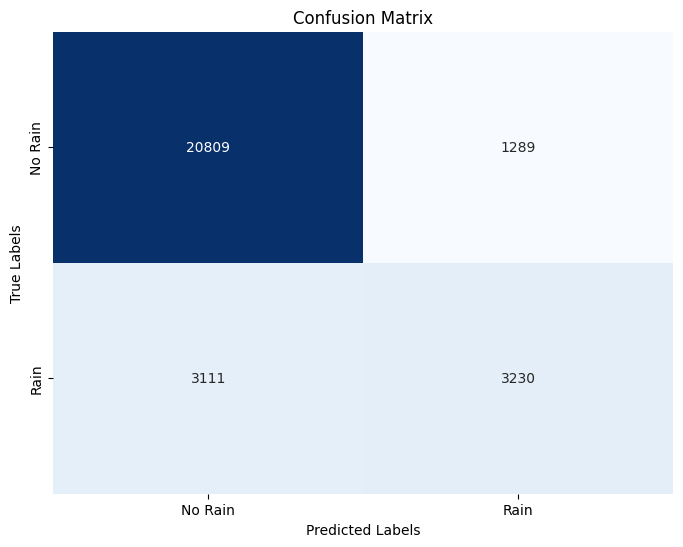

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Create labels for the classes
class_labels = ['No Rain', 'Rain']

# Create a pandas DataFrame from the confusion matrix
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


After generating the confusion matrix, we can further analyze the model's performance by calculating several important metrics. These metrics include the classification error (misclassification rate), precision, recall (sensitivity or true positive rate), F1 score, and specificity (true negative rate). Each metric provides unique insights into the model's ability to correctly or incorrectly classify observations.
### Output:


*   Classification Error: Indicates the proportion of total predictions that were incorrect. A lower classification error suggests a better-performing model.
*   Precision: Measures the accuracy of positive predictions. In the context of predicting rain, it indicates how reliable the model is when it forecasts rain.
*   Recall (Sensitivity): Reflects the model's ability to correctly identify actual positives. A higher recall means the model is better at catching all positive cases (rain days).
*   F1 Score: Provides a single score that balances both precision and recall, useful when you want to balance the importance of false positives and false negatives.
*   Specificity: Measures the model's ability to correctly identify actual negatives. High specificity indicates the model is good at avoiding false alarms.

In [ ]:
# Assuming 'cm' is the confusion matrix you've already calculated
TP = cm[1, 1]  # True Positives: Rain correctly predicted as Rain
TN = cm[0, 0]  # True Negatives: No Rain correctly predicted as No Rain
FP = cm[0, 1]  # False Positives: No Rain incorrectly predicted as Rain
FN = cm[1, 0]  # False Negatives: Rain incorrectly predicted as No Rain

# Classification Error (Misclassification Rate): Overall, how often is the classifier incorrect?
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print(f'Classification Error: {classification_error}')

# Precision: When it predicts Rain, how often is it correct?
precision = TP / float(TP + FP)
print(f'Precision: {precision}')

# Recall (Sensitivity or True Positive Rate): How often is the prediction correct when it's actually Rain?
recall = TP / float(FN + TP)
print(f'Recall: {recall}')

# F1 Score: A weighted average of Precision and Recall.
f1_score = 2 * (precision * recall) / (precision + recall)
print(f'F1 Score: {f1_score}')

# Specificity (True Negative Rate): How often is the prediction correct when it's actually No Rain?
specificity = TN / (TN + FP)
print(f'Specificity: {specificity}')


Classification Error: 0.15471711382256761
Precision: 0.714759902633326
Recall: 0.5093833780160858
F1 Score: 0.5948434622467771
Specificity: 0.9416689293148701


In evaluating the performance of our binary classification model, the Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (ROC-AUC) score are powerful tools. The ROC curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings, providing insights into the balance between true positive outcomes and false positives. The ROC-AUC score quantifies the overall ability of the model to discriminate between the positive and negative classes across all thresholds.

### Generating the ROC Curve and Calculating the ROC-AUC Score
#### Finding the Optimal Threshold
The optimal threshold balances sensitivity and specificity, maximizing the model's ability to correctly classify positive instances while minimizing false positives
#### Visualizing the ROC Curve
We plot the ROC curve to visualize the trade-off between TPR and FPR at different thresholds, including marking the optimal threshold identified.
#### Adjusting Predictions Based on the Optimal Threshold
After identifying the optimal threshold, we can adjust our model's predictions, which can improve the model's classification performance by considering this threshold.ed.

ROC-AUC Score: 0.8666000282693647
Optimal Threshold: 0.1853389290812578


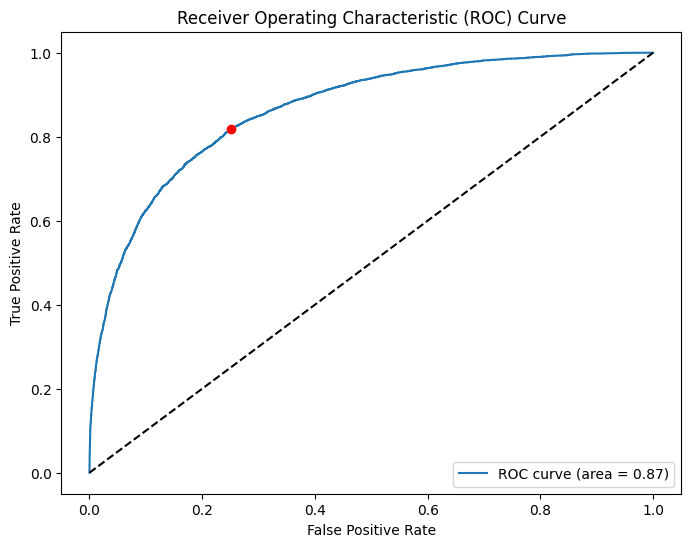

Adjusted Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.75      0.83     22098
           1       0.48      0.82      0.61      6341

    accuracy                           0.76     28439
   macro avg       0.71      0.78      0.72     28439
weighted avg       0.83      0.76      0.78     28439



In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import numpy as np

# Predict probabilities for the test set
y_probs = logistic_model.predict_proba(X_test_df)[:, 1]  # Get probabilities of the positive class

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate the ROC-AUC score
roc_auc = roc_auc_score(y_test, y_probs)
print(f"ROC-AUC Score: {roc_auc}")

# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)  # Difference between True Positive Rate and False Positive Rate
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random predictions curve
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro')  # Optimal threshold point
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Adjust predictions based on the optimal threshold
y_pred_adjusted = np.where(y_probs >= optimal_threshold, 1, 0)

# Evaluate performance with the new threshold
print("Adjusted Classification Report:\n", classification_report(y_test, y_pred_adjusted))


Cross-validation is a robust method for assessing the performance of a machine learning model. It involves splitting the training dataset into `k` smaller sets (or folds), then training the model `k` times, each time using a different fold as the validation set and the remaining `k-1` folds as the training set. This process helps in evaluating the model's ability to generalize to an independent dataset and mitigates the problem of overfitting.

### Performing K-Fold Cross-Validation

In this section, we use 10-fold cross-validation to assess the performance of our Logistic Regression model. This method splits the training data into 10 parts, trains the model on 9 parts, and tests it on the remaining part. This process repeats 10 times, each time with a different part used as the test set.
### Output
Cross-Validation Accuracy: The average accuracy across all folds gives us an estimate of how the model is expected to perform on unseen data. An accuracy of 0.8484 suggests that our Logistic Regression model is quite reliable in its predictions.

Standard Deviation of CV Accuracy: The standard deviation indicates the variability of the model's accuracy across the folds. A low standard deviation (0.0028 in this case) implies that the model's performance is consistent across different subsets of the training data, enhancing our confidence in the model's stability and generalizability.

In [ ]:
from sklearn.model_selection import cross_val_score

# Initialize the Logistic Regression model
logistic_model_cv = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)

# Perform k-fold cross-validation (let's use k=10)
cv_scores = cross_val_score(logistic_model_cv, X_train_df, y_train, cv=10)

# Compute the average accuracy and standard deviation
cv_accuracy = np.mean(cv_scores)
cv_std = np.std(cv_scores)

print(f"10-Fold Cross-Validation Accuracy: {cv_accuracy:.4f}")
print(f"Standard Deviation of CV Accuracy: {cv_std:.4f}")


10-Fold Cross-Validation Accuracy: 0.8484
Standard Deviation of CV Accuracy: 0.0028


**Checking whether model has overfitting / underfitting problem? Tuning the regularization hyperparameter to fix the problem:**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Assuming X_train_df, X_test_df, y_train, y_test are already defined from the previous preprocessing steps

# Define the model
model = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)

# Define the parameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train_df, y_train)

print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

# Compare with the baseline model accuracy
baseline_model = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)
baseline_scores = cross_val_score(baseline_model, X_train_df, y_train, cv=5)
baseline_accuracy = np.mean(baseline_scores)
print(f"Baseline Model Accuracy: {baseline_accuracy:.4f}")

# Evaluate the tuned model on the test set
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test_df)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy with Tuned Hyperparameters: {test_accuracy:.4f}")

# Interpretation based on cross-validation and test accuracy
if grid_search.best_score_ > baseline_accuracy and test_accuracy < grid_search.best_score_ - 0.05:
    print("The model might be overfitting as the cross-validation score is significantly higher than the test accuracy.")
elif grid_search.best_score_ < baseline_accuracy and test_accuracy < 0.7:
    print("The model might be underfitting as both cross-validation and test accuracies are low.")
else:
    print("The model performance is balanced, with no clear signs of overfitting or underfitting.")


Best Hyperparameters: {'C': 1}
Best Cross-Validation Score: 0.8485
Baseline Model Accuracy: 0.8485
Test Accuracy with Tuned Hyperparameters: 0.8453
The model performance is balanced, with no clear signs of overfitting or underfitting.


**NAIVE BAYES**

**Fitting the model Naïve Bayes classifier**:

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Naive Bayes classifier
nb_classifier = GaussianNB()

# Fit the classifier on the preprocessed training data
nb_classifier.fit(X_train_df, y_train)

# Predict on the training data
y_train_pred_nb = nb_classifier.predict(X_train_df)

# Evaluate the model performance on the training set
train_accuracy_nb = accuracy_score(y_train, y_train_pred_nb)
print("Training Accuracy (Naive Bayes):", train_accuracy_nb)
print("Training Classification Report (Naive Bayes):\n", classification_report(y_train, y_train_pred_nb))

# Predict on the preprocessed test data
y_test_pred_nb = nb_classifier.predict(X_test_df)

# Evaluate the model performance on the test set
test_accuracy_nb = accuracy_score(y_test, y_test_pred_nb)
print("Test Accuracy (Naive Bayes):", test_accuracy_nb)
print("Test Classification Report (Naive Bayes):\n", classification_report(y_test, y_test_pred_nb))


Training Accuracy (Naive Bayes): 0.6559681417796297
Training Classification Report (Naive Bayes):
               precision    recall  f1-score   support

           0       0.89      0.64      0.74     88218
           1       0.36      0.72      0.48     25536

    accuracy                           0.66    113754
   macro avg       0.63      0.68      0.61    113754
weighted avg       0.77      0.66      0.68    113754

Test Accuracy (Naive Bayes): 0.6509019304476248
Test Classification Report (Naive Bayes):
               precision    recall  f1-score   support

           0       0.89      0.63      0.74     22098
           1       0.36      0.72      0.48      6341

    accuracy                           0.65     28439
   macro avg       0.62      0.67      0.61     28439
weighted avg       0.77      0.65      0.68     28439



**Summarizing the performance of a classification algorithm using confusion matrix and visualizing confusion matrix with seaborn heatmap:**

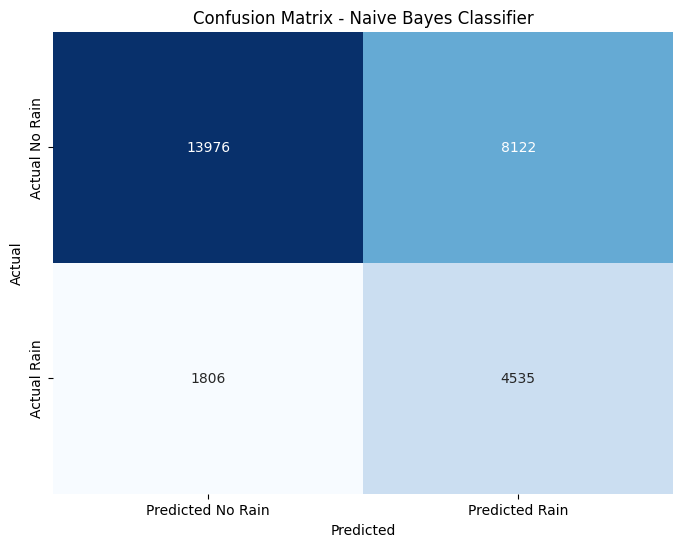

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix for the Naive Bayes classifier on the test data
cm_nb = confusion_matrix(y_test, y_test_pred_nb)

# Create a pandas DataFrame from the confusion matrix for better label handling in the heatmap
cm_df_nb = pd.DataFrame(cm_nb,
                        index=['Actual No Rain', 'Actual Rain'],
                        columns=['Predicted No Rain', 'Predicted Rain'])

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df_nb, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Naive Bayes Classifier')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


**Displaying the Classification error, Precision, Recall , F1 score and  Specificity scores for the model:**

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming 'cm_nb' is the confusion matrix for the Naive Bayes model
TP = cm_nb[1, 1]  # True Positives
TN = cm_nb[0, 0]  # True Negatives
FP = cm_nb[0, 1]  # False Positives
FN = cm_nb[1, 0]  # False Negatives

# Classification Error (also known as Misclassification Rate)
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print(f'Classification Error: {classification_error}')

# Precision
precision = precision_score(y_test, y_test_pred_nb)  # Or TP / float(TP + FP)
print(f'Precision: {precision}')

# Recall (Sensitivity or True Positive Rate)
recall = recall_score(y_test, y_test_pred_nb)  # Or TP / float(FN + TP)
print(f'Recall: {recall}')

# F1 Score
f1 = f1_score(y_test, y_test_pred_nb)  # Or 2 * (precision * recall) / (precision + recall)
print(f'F1 Score: {f1}')

# Specificity (True Negative Rate)
specificity = TN / (TN + FP)
print(f'Specificity: {specificity}')


Classification Error: 0.34909806955237527
Precision: 0.3582997550762424
Recall: 0.7151868790411607
F1 Score: 0.4774186756500684
Specificity: 0.6324554258303919


**Adjusting the classification threshold levels/decision boundary to improve the performance of the classifier using ROC curve & ROC-AUC score:**

ROC-AUC Score (Naive Bayes): 0.7387315944576802


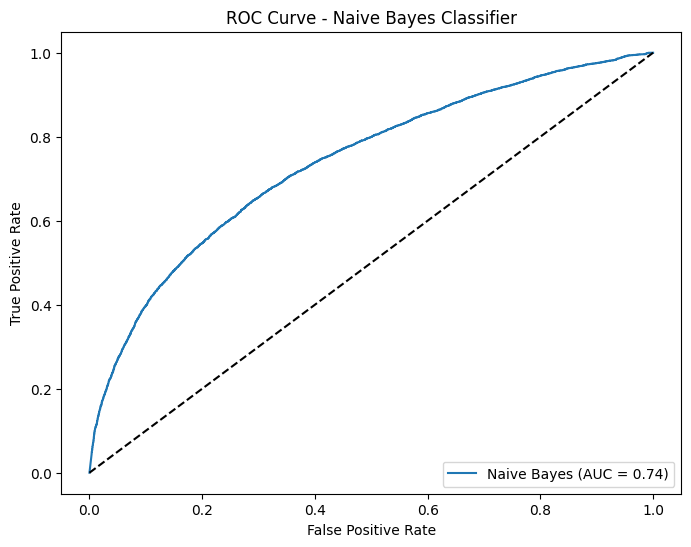

Optimal Threshold based on Youden's J statistic: 0.9295274846886432


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predict probabilities for the test set
y_probs_nb = nb_classifier.predict_proba(X_test_df)[:, 1]  # Probabilities of the positive class

# Calculate ROC curve
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, y_probs_nb)

# Calculate the ROC-AUC score
roc_auc_nb = roc_auc_score(y_test, y_probs_nb)
print(f"ROC-AUC Score (Naive Bayes): {roc_auc_nb}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive Bayes Classifier')
plt.legend(loc="lower right")
plt.show()

# Optional: Find an optimal threshold (example method based on Youden’s J statistic)
optimal_idx_nb = np.argmax(tpr_nb - fpr_nb)
optimal_threshold_nb = thresholds_nb[optimal_idx_nb]
print(f"Optimal Threshold based on Youden's J statistic: {optimal_threshold_nb}")


**Performing k-fold cross validation and check whether the cross-validation results in performance improvement or not:**

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

# Assuming X_train_df and y_train are already defined and preprocessed

# Initialize the Naive Bayes classifier
nb_classifier_cv = GaussianNB()

# Perform 10-fold cross-validation
cv_scores_nb = cross_val_score(nb_classifier_cv, X_train_df, y_train, cv=10, scoring='accuracy')

# Compute the average accuracy and standard deviation
cv_accuracy_nb = np.mean(cv_scores_nb)
cv_std_nb = np.std(cv_scores_nb)

print(f"10-Fold Cross-Validation Accuracy (Naive Bayes): {cv_accuracy_nb:.4f}")
print(f"Standard Deviation of CV Accuracy (Naive Bayes): {cv_std_nb:.4f}")

# Interpretation
if cv_accuracy_nb > 0.75 and cv_std_nb < 0.05:
    print("The model has high and consistent accuracy across folds, indicating good performance and generalization.")
elif cv_accuracy_nb > 0.75 and cv_std_nb >= 0.05:
    print("The model has high accuracy but with variability across folds, indicating potential overfitting to certain subsets.")
elif cv_accuracy_nb <= 0.75:
    print("The model shows room for improvement in accuracy across folds.")


10-Fold Cross-Validation Accuracy (Naive Bayes): 0.6551
Standard Deviation of CV Accuracy (Naive Bayes): 0.0061
The model shows room for improvement in accuracy across folds.


**Perform k-fold cross validation and check whether the cross-validation results in performance improvement or not:**

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB

# Define a pipeline that selects the k best features and then performs Gaussian Naive Bayes
pipeline = make_pipeline(SelectKBest(f_classif), GaussianNB())

# Define the parameter grid to search over
param_grid = {'selectkbest__k': [10, 20, 30, 40, 50]}  # Adjust these values based on the total number of features

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train_df, y_train)

print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")


Best Hyperparameters: {'selectkbest__k': 10}
Best Cross-Validation Score: 0.7922


**Check whether model has overfitting / underfitting problem and tuning the regularization hyperparameter to fix the problem:**

In [ ]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
import numpy as np

# Assuming X_train_df and y_train are defined and preprocessed

# Create a pipeline with feature selection and Naive Bayes classifier
pipeline = Pipeline([
    ('feature_selection', SelectKBest(f_classif)),
    ('nb', GaussianNB())
])

# Define parameters for grid search (number of features to select)
param_grid = {
    'feature_selection__k': [10, 20, 30, 40, 50]  # Adjust these numbers based on your total number of features
}

# Setup the grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train_df, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Evaluate on the test set using the best found parameters
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test_df, y_test)
print("Test set score with best parameters: {:.2f}".format(test_score))

# Further assess if the model is overfitting or underfitting
train_score = best_model.score(X_train_df, y_train)
print(f"Training score: {train_score:.2f}")

# Comparing training score with test score
if train_score > test_score + 0.1:
    print("The model might be overfitting.")
elif train_score < 0.7 and test_score < 0.7:
    print("The model might be underfitting.")
else:
    print("The model has a balanced fit.")


Best parameters: {'feature_selection__k': 10}
Best cross-validation score: 0.79
Test set score with best parameters: 0.79
Training score: 0.79
The model has a balanced fit.
